# SBRCT Microarray Data
Gene expression arrays are an important new technology in biology. The data for this example form a matrix of 2308 genes (columns) and 63 samples (rows), from a set of microarray experiments. Each expression value is a log-ratio $log(R/G)$. $R$ is the amount of gene-specific RNA in the target sample that hybridizes to a particular (gene-specific) spot on the microarray, and $G$ is the corresponding amount of RNA from a reference sample. The samples arose from small, round blue-cell tumors (SRBCT) found in children, and are classified into four major types: BL (Burkitt lymphoma), EWS (Ewing's sarcoma), NB (neurablastoma), and RMS (rhabdomyosarcoma). There is an additional test data set of 20 observations.
SBRCT gene expression data.

Cancer classes are labelled 1,2,3,4 for c("BL", "EWS", "NB", "RMS")

The implementation is based on the "Diagnosis of multiple cancer types by shrunkencentroids of gene expression", Robert Tibshirani, Trevor Hastie, Balasubramanian Narasimhan, and Gilbert Chu, https://www.pnas.org/content/pnas/99/10/6567.full.pdf

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score

%matplotlib inline

# define commonly used colors
GRAY1, GRAY4, GRAY8, PURPLE = '#231F20', '#646369', '#A6A6A5', '#A020F0'
BLUE, ORANGE, BLUE1 = '#57B5E8', '#E69E00', '#174A7E'
# configure plot font family to Arial
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5

## Load and Prepare Data

In [2]:
data = np.load('../data/srbct.npy.npz')['data']

# last column contains 'is train' flag
is_train = data[:,-1].astype(int)
data_test = data[is_train == 0, :]
data_train = data[is_train == 1, :]
# pre-last column contains class
y_train = data_train[:, -2].astype(int)
y_test = data_test[:, -2].astype(int)
X_train = data_train[:, :-2]
X_test = data_test[:, :-2]

## Nearest Shrunken Centroids
The Scikit-Learn provides NearestCentroid class that supports shrink_threshold. It is not very powerfull and its result is different from the book, but it gives 100% test accuracy anyway. Next step we will implement our algorithm.

In [3]:
stratified_kfolds = StratifiedKFold(8, random_state=1)
nearest_centroid_classifier = Pipeline([
    ('scale', StandardScaler()),
    ('ncc', NearestCentroid())]
)
# use grid search to select best shrink_threshold
shrink_threshold_grid_search = GridSearchCV(
    nearest_centroid_classifier,
    {'ncc__shrink_threshold': np.linspace(0, 100, 100)},
    cv=stratified_kfolds,
    iid=True
).fit(X_train, y_train)
best_model = shrink_threshold_grid_search.best_estimator_
print('Test accuracy score',
      accuracy_score(y_test, best_model.predict(X_test)))

Test accuracy score 1.0


## Nearest Shrunken Centroids Implementation
To get the same result as in the book, let's implement the nearest shrunken centroids model ourselves. Although the result is very close, it is slightly different. It uses 8-fold cross validation instead of 10-fold, as in the book. We get 100% test accuracy and the best cross-validation result with 37 selected genes.

In [4]:
class ShrunkenCentroid(BaseEstimator, ClassifierMixin):
    """Nearest shrunken centroid classifier.
    Each class is represented by its centroid, with test samples classified to
    the class with the nearest centroid.
    Parameters
    ----------
    delta : float, optional (default = None)
        Delta for shrinking centroids to remove features.
    Attributes
    ----------
    classes_:
        All classes found in the training data set.
    centroids_ :
        Centroid of each class.
    overall_centroid_:
        The overall mean of each feature.
    priors_:
        Class prior probabilities.
    vars_:
        Pooled within-class variances of features.
    shrunken_centroids_:
        Shrunken centroid of each class.
    features_used_:
        The indices of features that are not shrunken to the overall centroid.
    """
    def __init__(self, delta: float = 0):
        self.delta = delta

    def fit(self, X: np.ndarray, y: np.array) -> 'ShrunkenCentroid':
        """
        Fit the ShrunkenCentroid model according to the given training data.
        Parameters
        ----------
        X :
            Training vector, where n_samples is the number of samples and
            n_features is the number of features.
        y :
            Target values (integers)
        """
        # relabel target values to start from zero
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)
        self.classes_ = label_encoder.classes_
        N, p, K = *X.shape, self.classes_.size
        # calculated overall centroid and prior probabilities
        self.overall_centroid_ = np.mean(X, axis=0)
        _, counts = np.unique(y, return_counts=True)
        self.priors_ = counts / N
        # calculate correction coefficients for each class
        m = np.atleast_2d((1/counts - 1/N)**0.5).T
        self.centroids_ =\
            np.vstack([np.mean(X[y == k, :], axis=0) for k in range(K)])
        # pooled within-class variance and deviation of features
        self.vars_ = np.zeros(shape=p)
        for k in range(K):
            self.vars_ += np.sum((X[y == k, :]-self.centroids_[k])**2, axis=0)
        self.vars_ /= (N - K)
        stds = self.vars_ ** 0.5
        # calculate shrunken centroids
        distances = self.centroids_ - self.overall_centroid_
        mean_std = np.median(stds)
        t_stats = distances / (stds + mean_std) / m
        t_stats_shrunken =\
            np.sign(t_stats) * (np.abs(t_stats) - self.delta).clip(0)
        self.shrunken_centroids_ =\
            self.overall_centroid_ + m * (stds + mean_std) * t_stats_shrunken
        self.features_used_ = np.squeeze(np.argwhere(np.sum(np.abs(
            self.shrunken_centroids_ - self.overall_centroid_), axis=0) > 0))
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Perform classification on an array of test vectors X.
        The predicted class C for each sample in X is returned.
        Parameters
        ----------
        X : array, shape = [n_samples, n_features]
        Returns
        -------
        C : array, shape = [n_samples]
        """
        N, K = X.shape[0], self.classes_.size
        discriminators = np.zeros(shape=(N, K))
        for i in range(N):
            discriminators[i] = -np.sum(
                (self.shrunken_centroids_ - X[i])**2 / self.vars_, axis=1) +\
                                2*np.log(self.priors_)
        return self.classes_[np.argmax(discriminators, axis=1)]

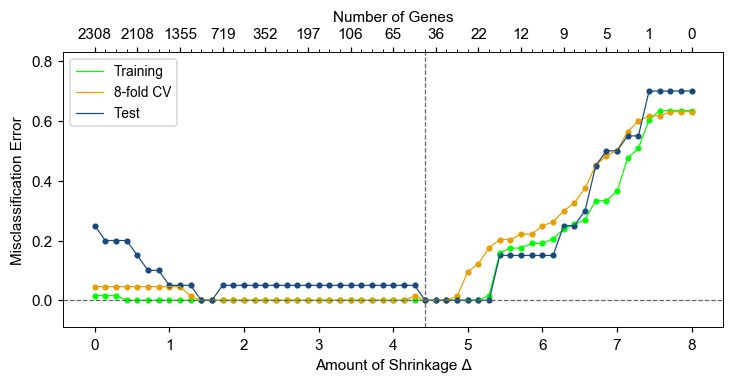

In [5]:
# PAGE 655. FIGURE 18.4 (Top): Error curves for the SRBCT data. Shown are the
#           training, 10-fold cross-validation, and test misclassification
#           errors as the threshold parameter Δ is varied. The value Δ = 4.34
#           is chosed by CV, resulting in a subset of 43 seleted genes.
# calculate
deltas = np.linspace(0, 8, 14*4 + 1)
n_genes, err_cv, err_train, err_test = [], [], [], []
for delta in deltas:
    sc = ShrunkenCentroid(delta=delta).fit(X_train, y_train)
    cv_accuracy = np.mean(cross_val_score(
        ShrunkenCentroid(delta=delta), X_train, y_train, cv=8))
    err_cv.append(1 - cv_accuracy)
    err_train.append(1 - sc.score(X_train, y_train))
    err_test.append(1 - sc.score(X_test, y_test))
    n_genes.append(sc.features_used_.size)
# plot
fig, ax = plt.subplots(figsize=(6, 2.5), dpi=110)
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
ax.scatter(deltas, err_train, c='#00FF00', s=9)
ax.plot(deltas, err_train, c='#00FF00', linewidth=0.8, label='Training')
ax.scatter(deltas, err_cv, c=ORANGE, s=9)
ax.plot(deltas, err_cv, c=ORANGE, linewidth=0.8, label='8-fold CV')
ax.scatter(deltas, err_test, c='#174A7E', s=9)
ax.plot(deltas, err_test, c='#174A7E', linewidth=0.8, label='Test')
ax.set_ylim(-0.09, 0.83)
ax.axhline(y=0, c=GRAY4, linewidth=0.8, linestyle='--')
ax.axvline(x=4.43, c=GRAY4, linewidth=0.8, linestyle='--')
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(deltas[::4])
ax2.set_xticks(deltas, minor=True)
ax2.set_xticklabels(n_genes[::4])
ax.set_xlabel('Amount of Shrinkage Δ')
ax.set_ylabel('Misclassification Error')
ax2.set_xlabel('Number of Genes')
_ = ax.legend(loc='upper left', prop={'size': 9})

In [6]:
# to get the same plot as in the book, let's set delta to 4.34 even though it
# gives not 100% test accuracy
shrunken_centroid_classifier = ShrunkenCentroid(
    delta=4.34).fit(X_train, y_train)
print(f'Number of genes used {shrunken_centroid_classifier.features_used_.size}')

Number of genes used 43


Text(1.2,-300,'Centroids: Average Expression Centered at Overall Centroid')

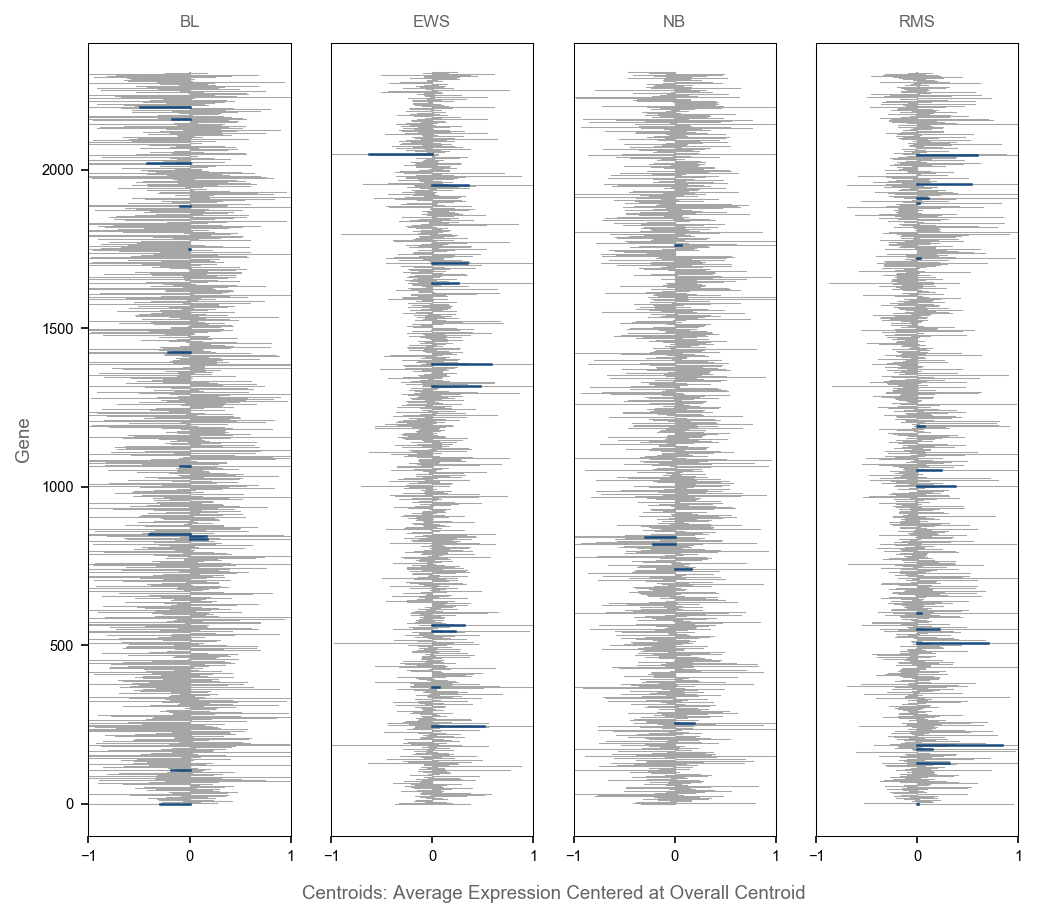

In [7]:
# PAGE 655. FIGURE 18.4 (Bottom): Four centroids profiles d_kj, for the SRBCT
#           data (gray), relative to the overall centroid. Each centroid has
#           2308 components, and we see considerable noise. The blue bars are
#           shrunken versions d'_kj of these centroids, obtained by
#           soft-thresholding the gray bars, using Δ = 4.3.
def plot_means(ax, model, class_index, title, hide_y_labels=True):
    means = model.centroids_[class_index] - model.overall_centroid_
    d_shrunken = model.shrunken_centroids_[class_index] - \
        model.overall_centroid_
    for i in range(means.shape[0]):
        ax.plot([0, means[i]], [i, i], linewidth=0.5, color=GRAY8)
    for i in range(d_shrunken.shape[0]):
        if d_shrunken[i] == 0:
            continue
        ax.plot([0, d_shrunken[i]], [i, i], linewidth=1.2, color='#174A7E')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-100, 2400)
    for i in ax.get_yticklabels() + ax.get_xticklabels():
        i.set_fontsize(7)
    if hide_y_labels:
        ax.tick_params(labelleft=False, left=False)
    else:
        ax.set_ylabel('Gene', color=GRAY4, fontsize=9)
    ax.text(0, 2450, title, color=GRAY4, fontsize=8,
        horizontalalignment='center')

fig, axarr = plt.subplots(
    1, 4, sharex=True, sharey=True, figsize=(8, 7), dpi=150)
plot_means(axarr[0], shrunken_centroid_classifier, 0, 'BL', False)
plot_means(axarr[1], shrunken_centroid_classifier, 1, 'EWS')
plot_means(axarr[2], shrunken_centroid_classifier, 2, 'NB')
plot_means(axarr[3], shrunken_centroid_classifier, 3, 'RMS')
axarr[1].text(
    1.2, -300, 'Centroids: Average Expression Centered at Overall Centroid',
    color=GRAY4, fontsize=9, horizontalalignment='center')

## Clustering

In [8]:
from scipy.cluster.hierarchy import linkage, leaves_list, fcluster
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm

# from training data select only the used for classification features
X_train_selected = X_train[:, shrunken_centroid_classifier.features_used_].T
# cluster and order observations within each class
ordered_class_samples = []
for k in shrunken_centroid_classifier.classes_:
    class_samples = X_train_selected[:, y_train == k]
    lnk = linkage(class_samples.T, method='average')
    ordered_class_samples.append(class_samples[:, leaves_list(lnk)])
X_train_selected = np.hstack(ordered_class_samples)

# group all used genes into 4 clusters
lnk = linkage(X_train_selected, method='complete')
genes_clusters = fcluster(lnk, 4, 'maxclust')
X_train_selected = np.vstack([X_train_selected[genes_clusters == k, :]
                              for k in [1, 2, 3, 4]])
# calculate cluster counts and cumsum for plotting
_, cluster_counts = np.unique(genes_clusters, return_counts=True)
clusters_cumsum = np.cumsum(cluster_counts)
# calculate classes counts and cumsum for plotting
_, class_counts = np.unique(y_train, return_counts=True)
class_cumsum = np.cumsum(class_counts)

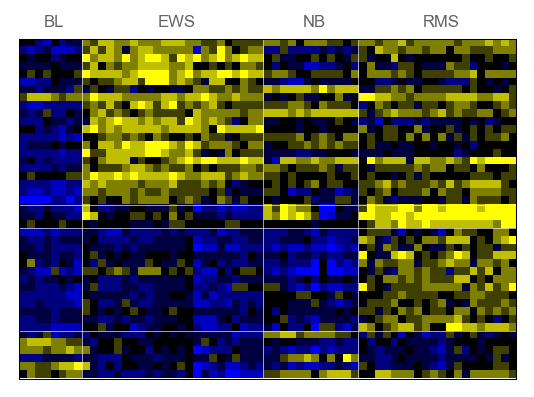

In [9]:
# PAGE 654. FIGURE 18.3 Heat-map of the chosen 43 genes. Within each of the
#           horizontal partitions, we have ordered the genes by hierarchical
#           clustering, and similarly for the samples within each vertical
#           partition. Yellow represents over- and blue under-expression.
cmap = LinearSegmentedColormap.from_list(
    'cm', ['blue', 'black', 'yellow'], N=256)
bounds = np.arange(-4, 3, 0.7)
norm = BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
ax.imshow(X_train_selected, interpolation='none', norm=norm, cmap=cmap)
ax.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)

for e in class_cumsum[:-1]:
    ax.axvline(e - 0.5, color='white', linewidth=0.3)
for e in clusters_cumsum[:-1]:
    ax.axhline(e - 0.5, color='white', linewidth=0.3)
for i, t in enumerate(['BL', 'EWS', 'NB', 'RMS']):
    x = (class_cumsum[i - 1] if i > 0 else 0) + class_counts[i] / 2
    ax.text(x, -2, t, color=GRAY4, fontsize=8, horizontalalignment='center')